In [1]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
from scipy.integrate import *
import numpy as np
import matplotlib.pyplot as plt
from cmath import *
from scipy.signal import *
from scipy import signal
from random import *

In [2]:
# setting ring parameters
# from PDK RMCTE_R5AP_LPN_WG_450

# coupled through coefficient
gamma = 0.95012

# modulation efficiency ( m/V, -0.5~0.5V )
# me = -38.7e-12
# # modulation efficiency ( m/V, -1~0.5V )
me = -37.2e-12

neff = 2.51464

# round trip tranmission coefficient (no unit)
alpha = 0.95246

# radius of ring
radius = 5e-6

# group velocity
ng = 4.3

# length of active region
La = 2*np.pi*radius

In [3]:
# driving parameters
square_wave = False
sine_wave =False
raise_cosine =True
PRBS = True
eye_diagram = True

# bit numbers of PRBS
N = 1000
# dc bias
v_bias = -1
# vpp
vpp = 1

# driving frequency (GHz)
f = 50
w_drive = 2*np.pi*f*1e9
if raise_cosine:
    T = 1/(f*1e9)

# series resistance
R = 53.9

# junction capacitance at difference bias
# according to PDK data
# if v_bias >=0:
#     Cj = 23.6e-15 
# if v_bias ==-1:
#     Cj = 20e-15 
# if v_bias ==-2:
#     Cj = 18.5e-15 
def Cj(V):
    return 3.7675e-14/( (2.5485-V)**0.5 )
    # return 20e-15



In [4]:
# calculating ring resonant frequency

# Since coupled mode theory in time only consider one resonant frequency. 
# When deriving w0, one must find the integar of 2pi which the resonant is near 1550nm .
# Note that the integar is even for resonant frequency, odd for anti-resonant frequency
c = 299792458
L=2*np.pi*radius
w0 = 102*np.pi*c/(neff*L)
lambda0 = 2*np.pi*c/w0

In [5]:
# setting incident light 
# incidnet light frequency or wavelength
change_lambda = True
change_w = False
if change_lambda:
    wl =1.5493e-6
    w = 2*np.pi*c/wl
if change_w:
    w = 102/102*w0
    wl =2*np.pi*c/w

In [6]:
# calculating parameter in couple mode equation in time

kappa = (1-gamma**2)**0.5

# photon life time in ring 
tu_o = -L*ng/(c*log(alpha))
tu_e = -L*ng/(c*log(sqrt(1-kappa**2)))



In [7]:
# setting solver parameters

# time interval 
t0 = 1e-12

# most high time accuracy in the result
dt = 1e-16

t_min=0
t_max = 200
if PRBS and raise_cosine:
    t_max = 1/(f*1e9)*N/t0
    t_total = np.array([])
    t_all_segment = np.zeros((N,1)).tolist()
    # Generating Psuedo Random Bit Sequence
    T_v1 = T/t0
    for r in range(N):
        t_segment = np.arange(t_min+(r)*T_v1 +r*dt/t0, (r+1)*T_v1, dt/t0)
        t_total=np.append(t_total,t_segment)
        t_all_segment[r][0] = t_segment[0]
        t_all_segment[r].extend(t_segment[-len(t_segment)+1:-1])
else:
    t_total = np.arange(t_min,t_max,dt/t0)
    t_pround = t_total*t0

w_drive = 2*np.pi*f*1e9
b_init = 1e-6+1j*0
Q_init = 0

# relative solver tolerance 
rtol = 1e-15
# absolute solver tolerance
atol = 1e-20
# accuracy = atol + abs(y)*rtol

# method of solving algorithm
method = 'RK45'



# shifting frequency of field in ring from incident light frequency
w_pround = w

In [8]:
# normalize factors


S0 = 1
b0 = sqrt(t0)*S0
tu_t = (1/tu_e+1/tu_o)**(-1)
tu_t_bar = tu_t/t0
tu_e_bar = tu_e/t0

# normalized dw/dlambda
D_bar = -2*np.pi*c/lambda0**2 * t0

# normalized frequency
w0_bar = w0*t0
w_pround_bar = w_pround*t0


In [9]:
# Generating PRBS 
if PRBS:
    prbs =np.zeros(N)
    for i in range(N):
        prbs[i] = randint(0,1)
# prbs = [0,1]

In [10]:
# defining functions

# incident light
def S_plus(w,t):
    return 1*np.exp(1j*w*t*t0)

# incident light (shifted to w_pround)
def S_plus_pround(t):
    return S_plus(w,t)*np.exp(-1j*w_pround*t*t0)

# driving voltage
def sinc(t):
    if t==0:
        return 1
    else:
        return np.sin(np.pi*t)/(np.pi*t)

def rcos(t,beta,T,shift,t0=t0):
    """
    input:
        shift:time shift of raise cosine function, must be integar of normalized T 
        T:period of a bit 
        t: giving time second(normalized)
    """
    T_normalized = T/t0
    if not (beta==0):
        if ((t-shift)*t0==T/2/beta or (t-shift)*t0==( -T/2/beta)):
            if PRBS:
                return prbs[int(shift/T_normalized)-1]*np.pi/4*sinc(1/2/beta)
            else:
                return sinc((t-shift)*t0/T)*np.pi/4*sinc(1/2/beta)
        else:
            if PRBS:
                if (T_normalized==0):
                    print(T_normalized==0)
                return prbs[int(shift/T_normalized)-1]*sinc((t-shift)*t0/T)*np.cos(np.pi*beta*(t-shift)*t0/T)/(1-(2*beta*(t-shift)*t0/T)**2)
            else:
                return sinc((t-shift)*t0/T)*np.cos(np.pi*beta*(t-shift)*t0/T)/(1-(2*beta*(t-shift)*t0/T)**2)
        
    # return a

def v(w_drive,t):
    if square_wave:
        return vpp/2*signal.square(w_drive*t*t0,duty=0.5)+v_bias
    if sine_wave:
        return vpp/2*np.exp(1j*w_drive*t*t0)+v_bias
    if raise_cosine:
        T_period = 1/(f*1e9)
        T_period_normalized = T_period/t0
        beta = 1
        # a = np.zeros(len(t_total))
        a=0
        # N = int(t_max*t0//(T_period))
        # a = vpp/2*rcos(t-5*T_period/t0,beta, T_period)+v_bias
        # print(N)
        for i in range(N):
            a +=  (vpp*rcos(t, beta, T_period,(i+1)*T_period_normalized))
        return a+v_bias-vpp/2  

    

# incident light (shifted to w_pround)
def S_plus_pround_bar(t):
    return S_plus_pround(t)/S0


In [11]:
# defining CMT function


# normalized coupling coefficient in time
kappa_time = sqrt(2/tu_e_bar)


def CMT(t_bar,eqs):
    b_bar , Q_pround = eqs
    f2 = (v(w_drive,t_bar)/(R*Cj(v(w_drive,t_bar)))*t0) - (1/( R*Cj( v(w_drive,t_bar) ) ) )*Q_pround*t0
    f1 = 1j*(w0_bar-w_pround_bar)*b_bar- (1/tu_t_bar)*b_bar + kappa_time *S_plus_pround_bar(t_bar)+1j*D_bar*me*Q_pround*b_bar
    
    return [ f1,f2 ]


In [12]:
# solving CMT
sol = solve_ivp(CMT ,[t_min ,t_max], [b_init, Q_init],method=method,t_eval = t_total,atol = atol,rtol = rtol)


c:\Users\kevin\anaconda3\Lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


In [ ]:
b_bar = (sol.y[0])
# t_vals = np.arange(t_min*t0,t_max*t0,dt)
# b_bar_vals = np.interp(t_vals, t_total*t0, b_bar)
a_bar_vals = b_bar*np.exp(1j*w_pround*t_total*t0)

s_minus_bar = (S_plus(w_pround,t_total)/S0-sqrt(2/tu_e_bar)*a_bar_vals)

In [ ]:
# prepare data for showing
v_show = np.zeros(len(t_total))
C_show = np.zeros(len(t_total))
for i in range(len(t_total)):
    v_show[i]=v(w_drive,t_total[i])
    C_show[i]=Cj(v_show[i])

KeyboardInterrupt: 

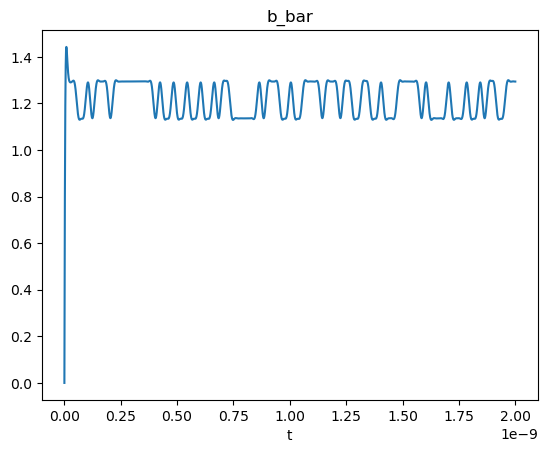

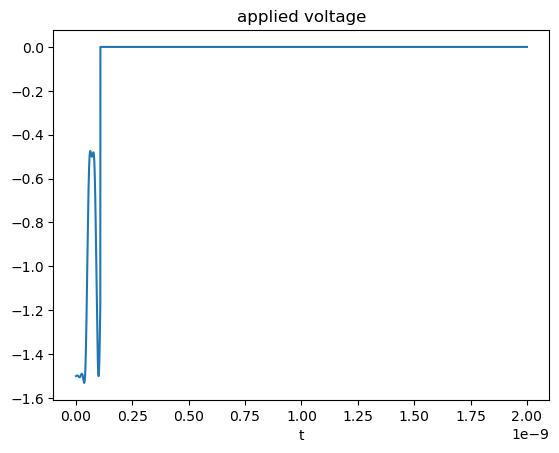

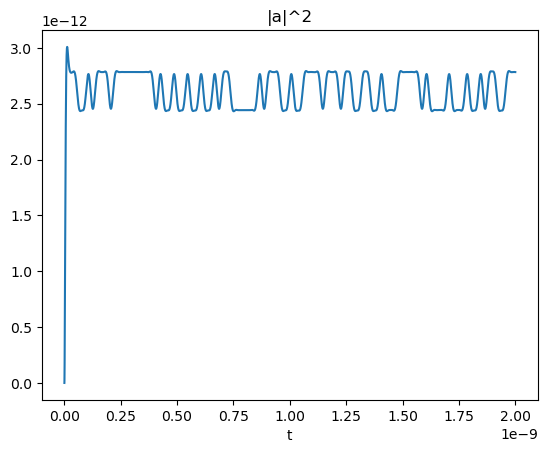

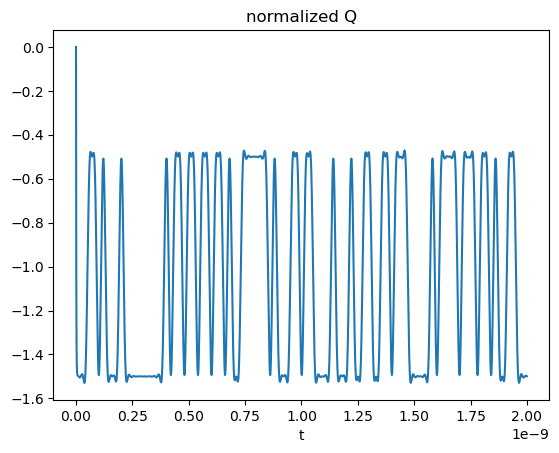

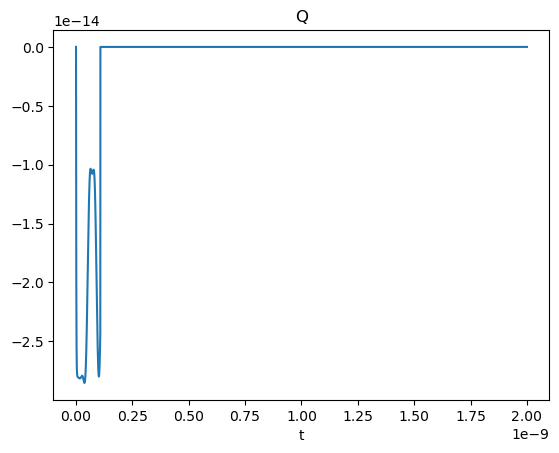

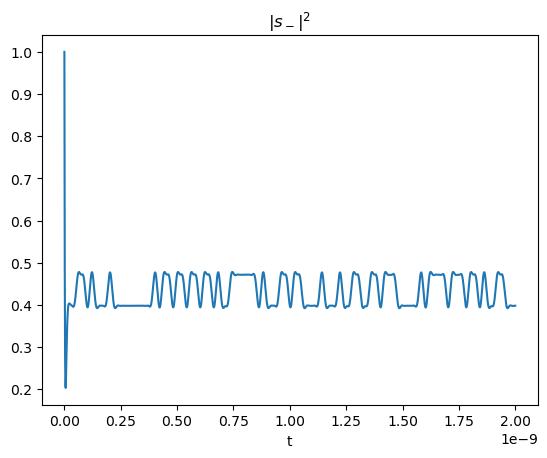

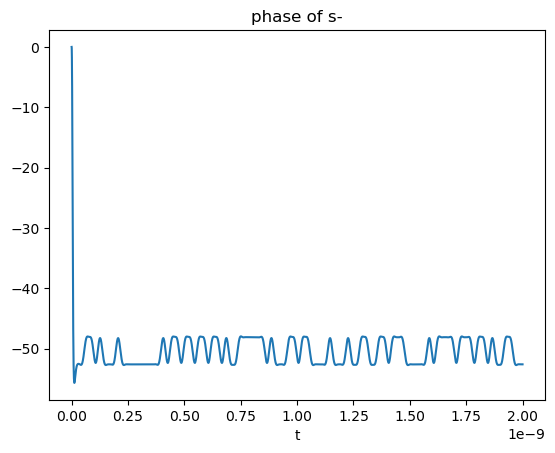

In [ ]:
plt.figure()
plt.plot(t_total*t0,b_bar )
plt.title("b_bar")
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total*t0, v_show)
plt.title("applied voltage")
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total*t0, abs(a_bar_vals*b0)**2)
plt.title(r"|a|^2")
plt.xlabel('t')
plt.show()

plt.figure()
plt.plot(t_total*t0, (sol.y[1]))
plt.title("normalized Q")
plt.xlabel('t')
plt.show()

# plt.figure()
# plt.plot(t_total*t0, C_show)
# plt.title("Cj")
# plt.xlabel('t')
# plt.show()

plt.figure()
plt.plot(t_total*t0, (sol.y[1])*C_show)
plt.title("Q")
plt.xlabel('t')
plt.show()

# plt.figure()
# plt.plot(t_total[-int(len(s_minus_bar)/10*2):-1]*t0, (sol.y[1][-int(len(s_minus_bar)/10*2):-1])*C_show[-int(len(s_minus_bar)/10*2):-1])
# plt.title("Q")
# plt.xlabel('t')
# plt.show()
# plt.figure()
# plt.plot(t_total[-260000:-250000]*t0, (sol.y[1][-260000:-250000])*C_show[-260000:-250000])
# plt.title("Q")
# plt.xlabel('t')
# plt.show()

plt.figure()
plt.plot(t_total*t0, abs(s_minus_bar*S0)**2)
plt.title(r'$|s_-|^2$')
plt.xlabel('t')
plt.show()

# plt.figure()
# plt.plot(t_total[-int(len(s_minus_bar)/10*2):-1]*t0, abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
# plt.title(r'$|s_-|^2$')
# plt.xlabel('t')
# plt.show()

plt.figure()
plt.plot(t_total*t0, 180/np.pi*np.angle(s_minus_bar*b0*np.exp(-1j*w*t_total*t0)))
plt.title(r'phase of s-')
plt.xlabel('t')
plt.show()

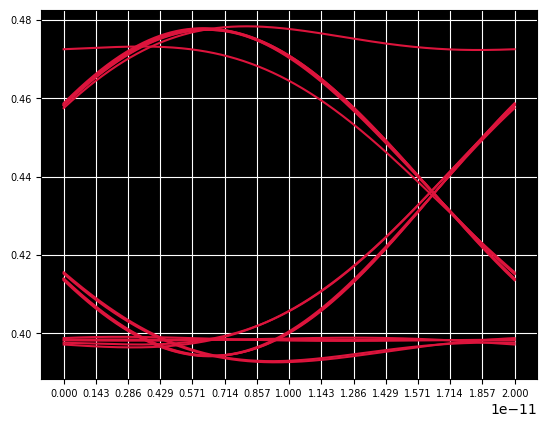

In [ ]:
if eye_diagram:
    cum_t_index = np.zeros(N)
    seg = t_all_segment[0]
    margin = 0.2
    blank = int(margin*len(seg))
    sig = abs(s_minus_bar[int((1-margin)*len(seg)):-1])**2
    for q in range(N):
        if q==0:
            cum_t_index[q] = int(len(t_all_segment[q]))
        else:
            cum_t_index[q] = int(len(t_all_segment[q]) + cum_t_index[q-1])
        T_normalized  = T/t0
    plt.figure()

    for k in range(N-1):
        if k==0:
            sig_segment = sig[int((1-margin)*len(seg)):int(cum_t_index[k])]
            plt.plot( t0*(np.array(t_all_segment[0][int((1-margin)*len(seg)):int(cum_t_index[k])])),sig_segment, color='crimson')
        else:
            sig_segment = sig[int(cum_t_index[k-1]):int(cum_t_index[k])]
            last = t_all_segment[k-1][-1]
            plt.plot( t0*(np.array(t_all_segment[k][:])-last),sig_segment, color='crimson')


    plt.grid(color='w')

    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xticks(np.linspace(t_min,t_min+T,15))
    # ax.set_yticks(np.linspace(v_bias+vpp/2,v_bias-vpp/2,15))
    ax.tick_params(axis='both', which='major', labelsize=7)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # plt.colorbar()
    fig = plt.gcf()

In [ ]:
prbs

array([0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.])

In [ ]:
phase_s_max = max(180/np.pi*np.angle(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0*np.exp(-1j*w*t_total[-int(len(s_minus_bar)/10*2):-1]*t0)))
phase_s_min = min(180/np.pi*np.angle(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0*np.exp(-1j*w*t_total[-int(len(s_minus_bar)/10*2):-1]*t0)))
print('max of s_minus = ',phase_s_max)
print('min of s_minus = ',phase_s_min)

max of s_minus =  -48.27182190560813
min of s_minus =  -52.699594904325664


In [ ]:
s_max = max(abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
s_min = min(abs(s_minus_bar[-int(len(s_minus_bar)/10*2):-1]*S0)**2)
print('max of s_minus = ',s_max)
print('min of s_minus = ',s_min)

max of s_minus =  0.47744702520546295
min of s_minus =  0.39637547925220507


In [ ]:
ER = 10*log10(s_max/s_min)
print("Extinction ratio = ", ER)

Extinction ratio =  (0.8081841162297911+0j)


In [ ]:
# Q factor of ring
Q_factor = (2/w0/tu_e + 2/w0/tu_o)**-1
print("Q factor of ring is ",np.real(Q_factor))

Q factor of ring is  2743.2132540748134


In [ ]:
max(t_total)

399.99999999498004